In [73]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import random
import sys
import time

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import pre-trained model
from keras.applications.vgg16 import VGG16

# include only those gestures
CONDITIONS = ['like', 'stop']

# image size
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

# Kernel Size for the convolution layers
## Choosing the values
In the given notebook, the values (3,3), (5,5) and (9,9) were used. I elected to additionally use the values (7,7) and (11,11), in order to have every uneven number aside from 1 represented. Any higher value seems silly considering that the images are of a 64x64 size.

## Expectation for results
I expected (11,11) to be too big for the model to be any more efficient than the other values. As for the other values, I had no idea. I flipped a coin between (5,5) and (7,7) and the coin chose that (7,7) would perform best.

## Results
All accuracy relevant plots are in the folder.
Inference times are the following:
- (3,3): 0.1428060531616211
- (5,5): 0.13826942443847656
- (7,7): 0.12648844718933105
- (9,9): 0.1713104248046875
- (11,11): 0.13759207725524902

Final epoch results are the following:
- (3,3): 15 Epochs, 15ms/step, accuracy: 0.9847, loss: 0.0433, val_accuracy: 0.9375, val_loss: 0.1778, learning_rate: 1.0000e-04
- (5,5): 9 Epochs, 14ms/step, accuracy: 0.9855, loss: 0.0534, val_accuracy: 0.9297, val_loss: 0.2243, learning_rate: 2.0000e-04
- (7,7): 13 Epochs, 19ms/step, accuracy: 0.9790, loss: 0.0578, val_accuracy: 0.9375, val_loss: 0.2500, learning_rate: 1.0000e-04
- (9,9): 19 Epochs, 25ms/step, accuracy: 0.9749, loss: 0.0667, val_accuracy: 0.9375, val_loss: 0.2206, learning_rate: 1.0000e-04
- (11,11): 16 Epochs, 34ms/step, accuracy: 0.9435, loss: 0.1497, val_accuracy: 0.9219, val_loss: 0.1990, learning_rate: 1.0000e-04


## Discussion
Interestingly enough, it was (9,9) that seemed to have the overall worst metrics, with the worst amount of epochs needed and by far the largest inference time. (11,11) had the worst accuracy with ~94%. The remaining values seem to not have too many differences, at least not large enough to determine one of them to be "the best". I assume that the kernel size will have different results for different image sizes, as a 64x64 image seems too small for larger kernel sizes.

## helper function to load and parse annotations

In [74]:
annotations = dict()
for condition in CONDITIONS:
    with open(f'_annotations/{condition}.json') as f:
        annotations[condition] = json.load(f)

In [75]:
# pretty-print first element
#print(json.dumps(annotations['like']['000484ab-5fd0-49b8-9253-23a22b71d7b1'], indent=2))

## helper function to pre-process images (color channel conversion and resizing)

In [76]:
def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

## load images and annotations

In [77]:
images = [] # stores actual image data
labels = [] # stores labels (as integer - because this is what our network needs)
label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for condition in CONDITIONS:
    for filename in tqdm(os.listdir(condition)):
        # extract unique ID from file name
        UID = filename.split('.')[0]
        img = cv2.imread(f'{condition}/{filename}')
        
        # get annotation from the dict we loaded earlier
        try:
            annotation = annotations[condition][UID]
        except Exception as e:
            print(e)
            continue
        
        # iterate over all hands annotated in the image
        for i, bbox in enumerate(annotation['bboxes']):
            # annotated bounding boxes are in the range from 0 to 1
            # therefore we have to scale them to the image size
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            
            # crop image to the bounding box and apply pre-processing
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            
            # get the annotated hand's label
            # if we have not seen this label yet, add it to the list of labels
            label = annotation['labels'][i]
            if label not in label_names:
                label_names.append(label)
            
            label_index = label_names.index(label)
            
            images.append(preprocessed)
            labels.append(label_index)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

## let's have a look at one of the images

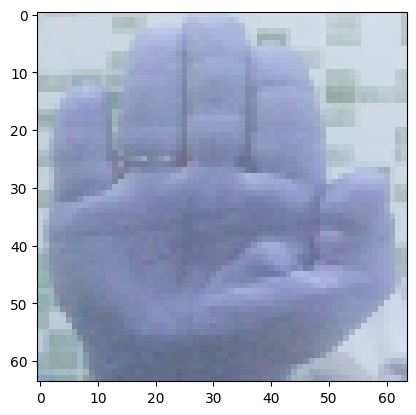

In [78]:
plt.imshow(random.sample(images, 1)[0])

## split data set into train and test

x is for the actual data, y is for the label (this is convention)

In [79]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

512
128
512
128


## transform data sets into a format compatible with our neural network

image data has to be a numpy array with following dimensions: [image_id, y_axis, x_axis, color_channels]

furthermore, scale all values to a range of 0 to 1

training data has to be converted to a categorial vector ("one hot"):

[3] --> [0, 0, 0, 1, 0, ..., 0]

In [80]:
X_train = np.array(X_train).astype('float32')
X_train = X_train / 255.

X_test = np.array(X_test).astype('float32')
X_test = X_test / 255.

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

train_label = y_train_one_hot
test_label = y_test_one_hot

X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

print(X_train.shape, X_test.shape, train_label.shape, test_label.shape)

(512, 64, 64, 3) (128, 64, 64, 3) (512, 3) (128, 3)


In [81]:
# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'leaky_relu'  # LeakyReLU
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
#model.add(Conv2D(64, kernel_size=(3, 3), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(Conv2D(64, kernel_size=(5, 5), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
#model.add(Conv2D(64, kernel_size=(7, 7), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
#model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
#model.add(Conv2D(64, kernel_size=(11, 11), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

#model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
#model.add(Conv2D(32, (7, 7), activation=activation_conv, padding='same'))
#model.add(Conv2D(32, (9, 9), activation=activation_conv, padding='same'))
#model.add(Conv2D(32, (11, 11), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

#model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
#model.add(Conv2D(32, (7, 7), activation=activation_conv, padding='same'))
#model.add(Conv2D(32, (9, 9), activation=activation_conv, padding='same'))
#model.add(Conv2D(32, (11, 11), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

c:\Users\richi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## now, we can train the model using the fit() function
## this will take a while

In [82]:
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.4526 - loss: 1.0373 - val_accuracy: 0.5078 - val_loss: 0.9820 - learning_rate: 0.0010
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6016 - loss: 0.9121 - val_accuracy: 0.7266 - val_loss: 0.6460 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7710 - loss: 0.6009 - val_accuracy: 0.8906 - val_loss: 0.3746 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8757 - loss: 0.3379 - val_accuracy: 0.9219 - val_loss: 0.2719 - learning_rate: 0.0010
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9079 - loss: 0.2786 - val_accuracy: 0.9062 - val_loss: 0.2700 - learning_rate: 0.0010
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9337 - loss: 0.3060 - val_accuracy: 0.9141 - val_loss: 0.3762 - learning_rate: 0.0010
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9567 - loss: 0.1459 - val_acc

In [87]:
# let's have a look at our model
#model.summary()
np.random.seed(69)
test_id = np.random.randint(0, X_test.shape[0])
test_image = X_test[test_id:test_id+1]

start_time = time.time()
void = model.predict(test_image)
end_time = time.time()
print(end_time-start_time)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
0.09051156044006348


## Plot accuracy and loss of the training process

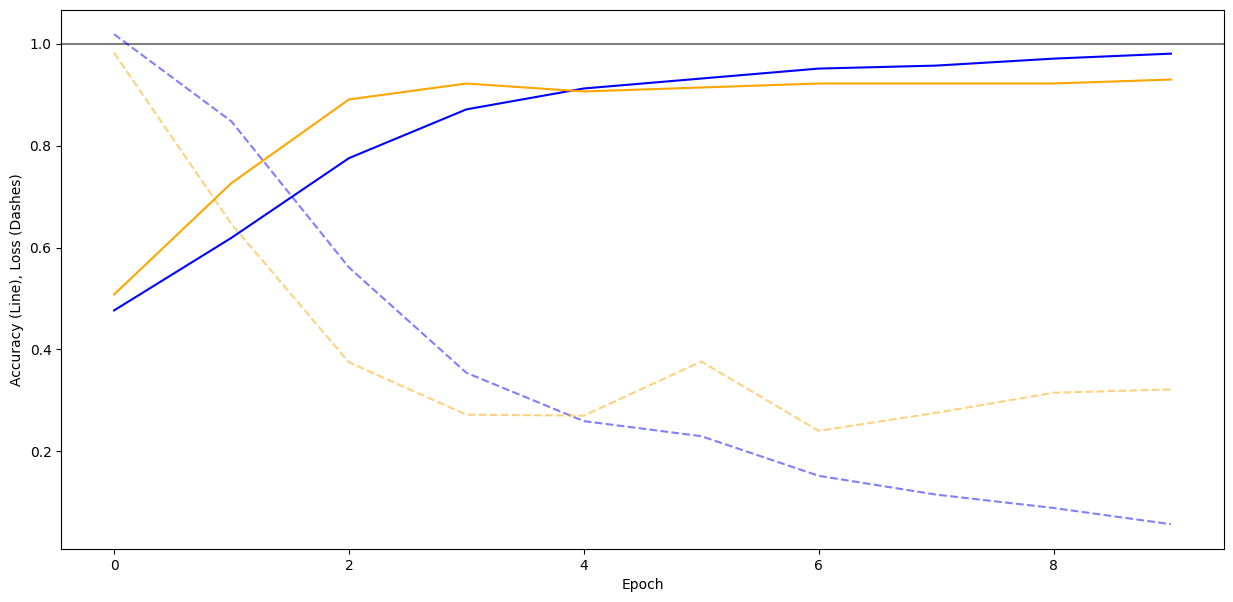

In [84]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

## saving the model

the function will create a directory for your model and save structure and weights in there

sometimes you will see the .h5 format being used - even though this is a bit faster and needs less space, it comes with its limitations and isn't used that much any more

In [85]:
model.save('gesture_recognition.keras')

# and this is how you load the model
# model = keras.models.load_model("gesture_recognition")

## visualize classification results with a confusion matrix

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
before [[6.31758245e-03 7.95390315e-06 9.93674517e-01]
 [9.98405516e-01 9.51949041e-04 6.42623228e-04]
 [9.51237738e-01 4.55775044e-05 4.87166941e-02]
 [1.28290732e-04 2.73103865e-06 9.99868989e-01]
 [9.97616291e-01 1.09226377e-04 2.27459171e-03]
 [9.99993324e-01 4.16839111e-06 2.52265522e-06]
 [9.99644995e-01 4.07637890e-06 3.50914896e-04]
 [1.83677286e-01 7.84649432e-01 3.16732861e-02]
 [9.99013424e-01 7.74604487e-05 9.09150171e-04]
 [9.96016085e-01 1.96479028e-04 3.78740230e-03]
 [7.39362531e-06 8.62900379e-07 9.99991775e-01]
 [3.21185653e-05 9.99965310e-01 2.61931291e-06]
 [6.12330019e-01 3.14495683e-01 7.31742680e-02]
 [2.39199726e-04 7.45377429e-06 9.99753296e-01]
 [9.99994755e-01 2.31465442e-08 5.24135658e-06]
 [4.29994339e-04 1.08347804e-05 9.99559104e-01]
 [3.35008488e-04 9.99651432e-01 1.35896626e-05]
 [1.94052245e-05 5.06093301e-08 9.99980569e-01]
 [1.47276632e-02 9.77978647e-01 7.29364995e-03]
 [5.62531823e-05 6.42359225e-07 9.99943137e

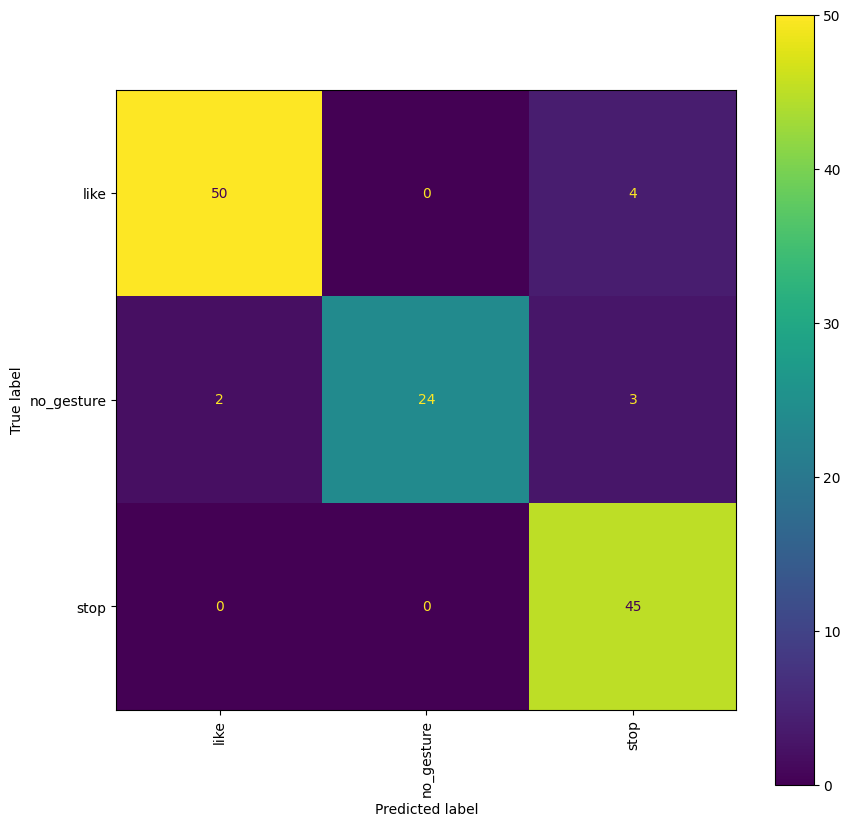

In [86]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass